In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
from aif360.datasets import StandardDataset
from aif360.metrics import BinaryLabelDatasetMetric, ClassificationMetric
import matplotlib.patches as patches
from aif360.algorithms.preprocessing import Reweighing
#from packages import *
#from ml_fairness import *
import matplotlib.pyplot as plt
import seaborn as sns



from IPython.display import Markdown, display

In [8]:
data = pd.read_csv("../../Data/adult.csv", header=0, index_col=None)

In [9]:
data.head(5)

,age,workclass,fnlwgt,education,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
0,90,?,77053,HS-grad,9,Widowed,?,Not-in-family,White,Female,0,4356,40,United-States,<=50K
1,82,Private,132870,HS-grad,9,Widowed,Exec-managerial,Not-in-family,White,Female,0,4356,18,United-States,<=50K
2,66,?,186061,Some-college,10,Widowed,?,Unmarried,Black,Female,0,4356,40,United-States,<=50K
3,54,Private,140359,7th-8th,4,Divorced,Machine-op-inspct,Unmarried,White,Female,0,3900,40,United-States,<=50K
4,41,Private,264663,Some-college,10,Separated,Prof-specialty,Own-child,White,Female,0,3900,40,United-States,<=50K


In [10]:
data["income"].value_counts()

<=50K    24720
>50K      7841
Name: income, dtype: int64

In [11]:
data.isnull().values.any()

False

In [12]:
data = data.replace("?", np.nan)

In [13]:
data.isnull().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education.num        0
marital.status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital.gain         0
capital.loss         0
hours.per.week       0
native.country     583
income               0
dtype: int64

In [14]:
null_data = data[pd.isnull(data).any(1)]
null_data["income"].value_counts()

<=50K    2066
>50K      333
Name: income, dtype: int64

In [15]:
data.dropna(inplace=True)

In [16]:
bins = (-1, 0, 5, 12, 18, 25, 35, 60, 120)
group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
categories = pd.cut(data["age"], bins, labels=group_names)
data["age"] = categories

<AxesSubplot:xlabel='count', ylabel='native.country'>

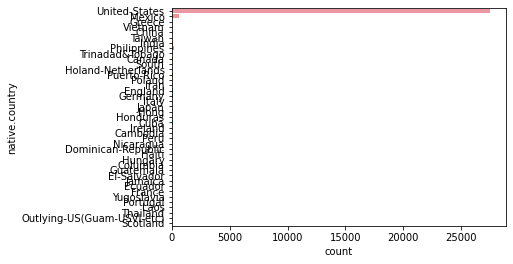

In [17]:
sns.countplot(y='native.country',data=data)

<AxesSubplot:xlabel='count', ylabel='education'>

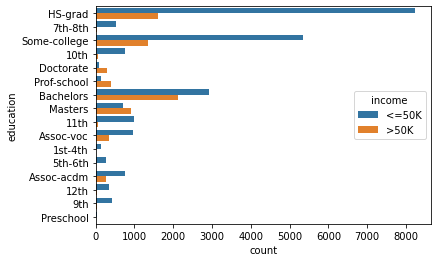

In [18]:
sns.countplot(y='education', hue='income', data=data)

<AxesSubplot:xlabel='count', ylabel='occupation'>

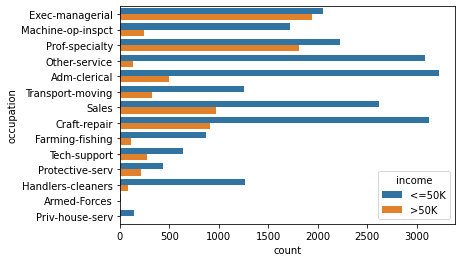

In [19]:
sns.countplot(y='occupation', hue='income', data=data)

In [20]:
# education = education.num
data.drop(["education", "fnlwgt"], axis=1, inplace=True)

In [21]:
from sklearn import preprocessing

In [22]:
for f in data:
    if f in ["age", "workclass", "marital.status", "occupation", "relationship", "race", "sex", "native.country", "income"]:
        le = preprocessing.LabelEncoder()
        le = le.fit(data[f])
        data[f] = le.transform(data[f])
data.head(5)

,age,workclass,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
1,1,2,9,6,3,1,4,0,0,4356,18,38,0
3,0,2,4,0,6,4,4,0,0,3900,40,38,0
4,0,2,10,5,9,3,4,0,0,3900,40,38,0
5,4,2,9,0,7,4,4,0,0,3770,45,38,0
6,0,2,6,5,0,4,4,1,0,3770,40,38,0


In [23]:
y = data["income"]
X = data.drop(["income"], axis=1)

In [18]:
from sklearn.ensemble import ExtraTreesClassifier

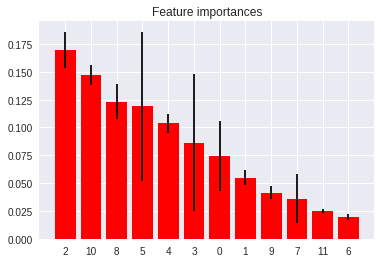

In [19]:
forest = ExtraTreesClassifier(n_estimators=100,random_state=0)

forest.fit(X, y)

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
indices = np.argsort(importances)[::-1]

plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [20]:
X = data.drop(["race", "native.country", "sex", "capital.loss", "workclass", "age"], axis=1)

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [24]:
forest = RandomForestClassifier(10)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [25]:
predictions = forest.predict_proba(X_test)
predictions = [np.argmax(p) for p in predictions]

In [26]:
precision = accuracy_score(predictions, y_test) * 100

In [27]:
print("Precision: {0}%".format(precision))

Precision: 100.0%


## Fairness

In [24]:
# This DataFrame is created to stock differents models and fair metrics that we produce in this notebook
algo_metrics = pd.DataFrame(columns=['model', 'fair_metrics', 'prediction', 'probs'])

def add_to_df_algo_metrics(algo_metrics, model, fair_metrics, preds, probs, name):
    return algo_metrics.append(pd.DataFrame(data=[[model, fair_metrics, preds, probs]], columns=['model', 'fair_metrics', 'prediction', 'probs'], index=[name]))

In [25]:
def fair_metrics(dataset, pred, pred_is_dataset=False):
    if pred_is_dataset:
        dataset_pred = pred
    else:
        dataset_pred = dataset.copy()
        dataset_pred.labels = pred
    
    cols = ['statistical_parity_difference', 'equal_opportunity_difference', 'average_abs_odds_difference',  'disparate_impact', 'theil_index']
    obj_fairness = [[0,0,0,1,0]]
    
    fair_metrics = pd.DataFrame(data=obj_fairness, index=['objective'], columns=cols)
    
    for attr in dataset_pred.protected_attribute_names:
        idx = dataset_pred.protected_attribute_names.index(attr)
        privileged_groups =  [{attr:dataset_pred.privileged_protected_attributes[idx][0]}] 
        unprivileged_groups = [{attr:dataset_pred.unprivileged_protected_attributes[idx][0]}] 
        
        classified_metric = ClassificationMetric(dataset, 
                                                     dataset_pred,
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)

        metric_pred = BinaryLabelDatasetMetric(dataset_pred,
                                                     unprivileged_groups=unprivileged_groups,
                                                     privileged_groups=privileged_groups)

        acc = classified_metric.accuracy()

        row = pd.DataFrame([[metric_pred.mean_difference(),
                                classified_metric.equal_opportunity_difference(),
                                classified_metric.average_abs_odds_difference(),
                                metric_pred.disparate_impact(),
                                classified_metric.theil_index()]],
                           columns  = cols,
                           index = [attr]
                          )
        fair_metrics = fair_metrics.append(row)    
    
    fair_metrics = fair_metrics.replace([-np.inf, np.inf], 2)
        
    return fair_metrics

def plot_fair_metrics(fair_metrics):
    fig, ax = plt.subplots(figsize=(20,4), ncols=5, nrows=1)

    plt.subplots_adjust(
        left    =  0.125, 
        bottom  =  0.1, 
        right   =  0.9, 
        top     =  0.9, 
        wspace  =  .5, 
        hspace  =  1.1
    )

    y_title_margin = 1.2

    plt.suptitle("Fairness metrics", y = 1.09, fontsize=20)
    sns.set(style="dark")

    cols = fair_metrics.columns.values
    obj = fair_metrics.loc['objective']
    size_rect = [0.2,0.2,0.2,0.4,0.25]
    rect = [-0.1,-0.1,-0.1,0.8,0]
    bottom = [-1,-1,-1,0,0]
    top = [1,1,1,2,1]
    bound = [[-0.1,0.1],[-0.1,0.1],[-0.1,0.1],[0.8,1.2],[0,0.25]]

    display(Markdown("### Check bias metrics :"))
    display(Markdown("A model can be considered bias if just one of these five metrics show that this model is biased."))
    for attr in fair_metrics.index[1:len(fair_metrics)].values:
        display(Markdown("#### For the %s attribute :"%attr))
        check = [bound[i][0] < fair_metrics.loc[attr][i] < bound[i][1] for i in range(0,5)]
        display(Markdown("With default thresholds, bias against unprivileged group detected in **%d** out of 5 metrics"%(5 - sum(check))))

    for i in range(0,5):
        plt.subplot(1, 5, i+1)
        ax = sns.barplot(x=fair_metrics.index[1:len(fair_metrics)], y=fair_metrics.iloc[1:len(fair_metrics)][cols[i]])
        
        for j in range(0,len(fair_metrics)-1):
            a, val = ax.patches[j], fair_metrics.iloc[j+1][cols[i]]
            marg = -0.2 if val < 0 else 0.1
            ax.text(a.get_x()+a.get_width()/5, a.get_y()+a.get_height()+marg, round(val, 3), fontsize=15,color='black')

        plt.ylim(bottom[i], top[i])
        plt.setp(ax.patches, linewidth=0)
        ax.add_patch(patches.Rectangle((-5,rect[i]), 10, size_rect[i], alpha=0.3, facecolor="green", linewidth=1, linestyle='solid'))
        plt.axhline(obj[i], color='black', alpha=0.3)
        plt.title(cols[i])
        ax.set_ylabel('')    
        ax.set_xlabel('')

In [26]:
def get_fair_metrics_and_plot(data, model, plot=False, model_aif=False):
    pred = model.predict(data).labels if model_aif else model.predict(data.features)
    # fair_metrics function available in the metrics.py file
    fair = fair_metrics(data, pred)

    if plot:
        # plot_fair_metrics function available in the visualisations.py file
        # The visualisation of this function is inspired by the dashboard on the demo of IBM aif360 
        plot_fair_metrics(fair)
        display(fair)
    
    return fair

In [27]:
data

,age,workclass,education.num,marital.status,occupation,relationship,race,sex,capital.gain,capital.loss,hours.per.week,native.country,income
1,1,2,9,6,3,1,4,0,0,4356,18,38,0
3,0,2,4,0,6,4,4,0,0,3900,40,38,0
4,0,2,10,5,9,3,4,0,0,3900,40,38,0
5,4,2,9,0,7,4,4,0,0,3770,45,38,0
6,0,2,6,5,0,4,4,1,0,3770,40,38,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,2,2,10,4,10,1,4,1,0,0,40,38,0
32557,4,2,12,2,12,5,4,0,0,0,38,38,0
32558,0,2,9,2,6,0,4,1,0,0,40,38,1
32559,0,2,9,6,0,4,4,0,0,0,40,38,0


In [28]:
privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]
dataset_orig = StandardDataset(data,
                                  label_name='income',
                                  protected_attribute_names=['sex'],
                                  favorable_classes=[1],
                                  privileged_classes=[[1]])


In [29]:
metric_orig_train = BinaryLabelDatasetMetric(dataset_orig, 
                                             unprivileged_groups=unprivileged_groups,
                                             privileged_groups=privileged_groups)
display(Markdown("#### Original training dataset"))
print("Difference in mean outcomes between unprivileged and privileged groups = %f" % metric_orig_train.mean_difference())

#### Original training dataset

Difference in mean outcomes between unprivileged and privileged groups = -0.200159


In [31]:
import ipynbname
nb_fname = ipynbname.name()
nb_path = ipynbname.path()

from sklearn.ensemble import ExtraTreesClassifier
import pickle

data_orig_train, data_orig_test = dataset_orig.split([0.7], shuffle=True)
X_train = data_orig_train.features
y_train = data_orig_train.labels.ravel()

X_test = data_orig_test.features
y_test = data_orig_test.labels.ravel()
num_estimators = 100

model = ExtraTreesClassifier(n_estimators=100)


mdl = model.fit(X_train, y_train)
with open('../../Results/ExtraTrees/' + nb_fname + '.pkl', 'wb') as f:
        pickle.dump(mdl, f)

with open('../../Results/ExtraTrees/' + nb_fname + '_Train' + '.pkl', 'wb') as f:
    pickle.dump(data_orig_train, f) 
    
with open('../../Results/ExtraTrees/' + nb_fname + '_Test' + '.pkl', 'wb') as f:
    pickle.dump(data_orig_test, f) 

In [32]:
from csv import writer
from sklearn.metrics import accuracy_score, f1_score

final_metrics = []
accuracy = []
f1= []

for i in range(1,num_estimators+1):
    
    model = ExtraTreesClassifier(n_estimators=i)

    
    mdl = model.fit(X_train, y_train)
    yy = mdl.predict(X_test)
    accuracy.append(accuracy_score(y_test, yy))
    f1.append(f1_score(y_test, yy))
    fair = get_fair_metrics_and_plot(data_orig_test, mdl)                           
    fair_list = fair.iloc[1].tolist()
    fair_list.insert(0, i)
    final_metrics.append(fair_list)


In [33]:
import numpy as np
final_result = pd.DataFrame(final_metrics)
print(final_result)
final_result[4] = np.log(final_result[4])
final_result = final_result.transpose()
final_result.loc[0] = f1  # add f1 and acc to df
acc = pd.DataFrame(accuracy).transpose()
acc = acc.rename(index={0: 'accuracy'})
final_result = pd.concat([acc,final_result])
final_result = final_result.rename(index={0: 'f1', 1: 'statistical_parity_difference', 2: 'equal_opportunity_difference', 3: 'average_abs_odds_difference', 4: 'disparate_impact', 5: 'theil_index'})
final_result.columns = ['T' + str(col) for col in final_result.columns]
final_result.insert(0, "classifier", final_result['T' + str(num_estimators - 1)])   ##Add final metrics add the beginning of the df
final_result.to_csv('../../Results/ExtraTrees/' + nb_fname + '.csv')
final_result

      0         1         2         3         4         5
0     1 -0.169958 -0.054357  0.070701  0.378880  0.144949
1     2 -0.163644 -0.123396  0.096670  0.310831  0.151513
2     3 -0.175222 -0.071477  0.078745  0.346804  0.140613
3     4 -0.163717 -0.080268  0.075465  0.333842  0.142432
4     5 -0.170513 -0.059918  0.068901  0.352157  0.135827
..  ...       ...       ...       ...       ...       ...
95   96 -0.172822 -0.057076  0.067821  0.339703  0.132871
96   97 -0.174847 -0.068320  0.072996  0.333625  0.131419
97   98 -0.170704 -0.056056  0.065994  0.342475  0.132731
98   99 -0.173072 -0.061690  0.069876  0.335022  0.133018
99  100 -0.172583 -0.061690  0.069517  0.335653  0.132911

[100 rows x 6 columns]


,classifier,T0,T1,T2,T3,T4,T5,T6,T7,T8,...,T90,T91,T92,T93,T94,T95,T96,T97,T98,T99
accuracy,0.839098,0.814013,0.824732,0.824179,0.832357,0.832799,0.831031,0.832910,0.836004,0.832578,...,0.837662,0.839319,0.837772,0.838988,0.838435,0.838104,0.840093,0.839098,0.838767,0.839098
f1,0.650336,0.608331,0.602307,0.624144,0.626631,0.639848,0.629692,0.640855,0.639806,0.638511,...,0.648984,0.651152,0.647793,0.651018,0.650407,0.649605,0.653911,0.650672,0.649868,0.650336
statistical_parity_difference,-0.172583,-0.169958,-0.163644,-0.175222,-0.163717,-0.170513,-0.172954,-0.178055,-0.165918,-0.171414,...,-0.170943,-0.172222,-0.174754,-0.173869,-0.175517,-0.172822,-0.174847,-0.170704,-0.173072,-0.172583
equal_opportunity_difference,-0.061690,-0.054357,-0.123396,-0.071477,-0.080268,-0.059918,-0.077402,-0.075775,-0.053313,-0.063512,...,-0.047096,-0.056566,-0.072958,-0.067567,-0.064750,-0.057076,-0.068320,-0.056056,-0.061690,-0.061690
average_abs_odds_difference,0.069517,0.070701,0.096670,0.078745,0.075465,0.068901,0.079333,0.079830,0.063740,0.071164,...,0.062680,0.067075,0.075794,0.072544,0.072484,0.067821,0.072996,0.065994,0.069876,0.069517
disparate_impact,-1.091678,-0.970537,-1.168507,-1.058995,-1.097086,-1.043679,-1.125540,-1.102060,-1.068276,-1.059270,...,-1.059940,-1.085089,-1.107941,-1.094003,-1.102907,-1.079684,-1.097736,-1.071557,-1.093558,-1.091678
theil_index,0.132911,0.144949,0.151513,0.140613,0.142432,0.135827,0.140408,0.135335,0.137164,0.136445,...,0.133012,0.132570,0.133700,0.132496,0.132584,0.132871,0.131419,0.132731,0.133018,0.132911
